# Fixed-time two-stage shooting optimization problem in CR3BP

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp

We will now import `stardust` - either add to path the root of the repository (as is done below), or simply `pip install python-stardust` (TBD). 

In [2]:
import sys
import os
sys.path.append('../../../')
import stardust

Let us first define some constants for the CR3BP dynamics.

In [3]:
# constants of CR3BP dynamics
mu = 1.215058560962404e-02
mu1 = 1 - mu
mu2 = mu

# canonical scalars
LU = 389703     # km
TU = 382981     # sec

Let us consider a problem where we want to transfer from one Earth-Moon L2 halo to another. The initial apolune states of two arbitrarily chosen halos are obtained from the JPL three-body database. 

We will propagate them over one period using `scipy`'s IVP solver and plot them to visualize the transfer we are attempting to do. 

In [4]:
# initial state
# rv0 = np.array([1.0809931218390707E+00,
#         0.0000000000000000E+00,
#         -2.0235953267405354E-01,
#         1.0157158264396639E-14,
#         -1.9895001215078018E-01,
#         7.2218178975912707E-15])
rv0 = np.array([1.018826173554963,
                0,
                 -0.179797844569828,
                0,
                -0.09618908984512,
                0])
period_0 = 2.3538670417546639E+00
sol0_ballistic = solve_ivp(stardust.eom_rotating_cr3bp, (0, period_0), rv0, args=(mu, mu1, mu2), 
                            method='RK45', rtol=1e-12, atol=1e-12)

# final targeted state
# rvf = np.array([1.1648780946517576,
#                 0.0,
#                 -1.1145303634437023E-1,
#                 0.0,
#                 -2.0191923237095796E-1,
#                 0.0])
rvf = np.array([0.823383959653906,
                0,
                0.010388134109586,
                0,
                0.128105259453086,
                0])
period_f = 3.3031221822879884
solf_ballistic = solve_ivp(stardust.eom_rotating_cr3bp, (0, period_f), rvf, args=(mu, mu1, mu2),
                            method='RK45', rtol=1e-12, atol=1e-12)

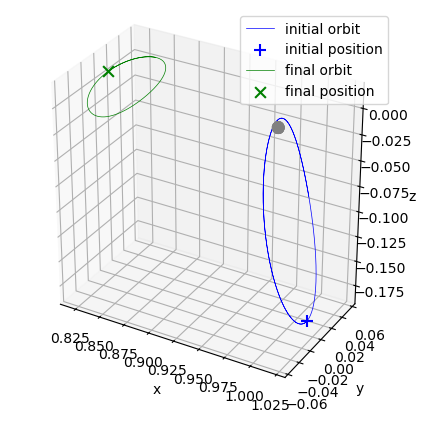

In [5]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot(sol0_ballistic.y[0, :], sol0_ballistic.y[1, :], sol0_ballistic.y[2, :], 
        color='blue', label='initial orbit', lw=0.5)
ax.scatter(sol0_ballistic.y[0,0], sol0_ballistic.y[1,0], sol0_ballistic.y[2,0], 
           color='blue', label='initial position', marker="+", s=80)

ax.plot(solf_ballistic.y[0, :], solf_ballistic.y[1, :], solf_ballistic.y[2, :],
        color='green', label='final orbit', lw=0.5)
ax.scatter(solf_ballistic.y[0,0], solf_ballistic.y[1,0], solf_ballistic.y[2,0], 
           color='green', label='final position', marker="x", s=60)

ax.legend()
stardust.plot_sphere_wireframe(ax, 1737/384400, [1-mu,0,0], color='grey')
ax.set(xlabel="x", ylabel="y", zlabel="z")
ax.set_aspect('equal', 'box')
plt.show()

We are looking for a transfer that connects the initial position to the final position. 

Let us now construct the `FixedTimeTwoStageOptimizer` object. 
As arguments, we need to provide:

- the dynamics function 
- initial position and velocity vectors
- final position and velocity vectors
- number of nodes `N`
- arguments to the equations of motion

The expected signature of the dynamics (first argument) is as follows: 

```python
def eom_stm(t, x_stm, *args):
    # unpack state and STM
    x = x_stm[:nx]                                        # state
    STM = x_stm[nx:].reshape(nx,nx)                       # STM

    # compute eom & store into 1D array to be returned
    deriv_x_stm = np.zeros(nx + nx*nx,)
    deriv_x_stm[:nx] = ...                                # state-derivative
    deriv_x_stm[nx:] = (Jacobian @ STM).reshape(nx*nx,)   # STM derivatives
    return deriv_x_stm
```

In [6]:
# construct problem
args = (mu, mu1, mu2)
# tspan = [0, 57.4*86400/TU]
tspan = [0, 29.5*86400/TU]
N = 80
prob = stardust.FixedTimeTwoStageOptimizer(
    stardust.eom_stm_rotating_cr3bp,
    rv0,
    rvf,
    tspan,
    N = N,
    args = args,
)

We are now ready to solve the problem!

In [7]:
print(f"Solving outer loop...")
tstart = time.time()
exitflag, iter_sols = prob.solve(maxiter = 10, save_all_iter_sols = True, verbose_inner = True)
tend = time.time()
print(f"Elapsed time = {tend - tstart} sec")
print(f"exitflag = {exitflag}")

Solving outer loop...
    Inner loop 0: max position residual norm: 3.7065e-03
    Inner loop 1: max position residual norm: 2.0814e-06
    Inner loop 2: max position residual norm: 6.2522e-13
    Inner loop converged to within tolerance 1e-11 in 2 iterations!
  Computing outer-loop sparse Jacobian...
Outer loop iteration 0 : cost = 4.5757e+00
    Inner loop 0: max position residual norm: 1.4298e-02
    Inner loop 1: max position residual norm: 2.8024e-06
    Inner loop 2: max position residual norm: 3.4512e-13
    Inner loop converged to within tolerance 1e-11 in 2 iterations!
  Computing outer-loop sparse Jacobian...
Outer loop iteration 1 : cost = 2.3478e+00
    Inner loop 0: max position residual norm: 2.4576e-02
    Inner loop 1: max position residual norm: 7.8495e-06
    Inner loop 2: max position residual norm: 2.0632e-12
    Inner loop converged to within tolerance 1e-11 in 2 iterations!
  Computing outer-loop sparse Jacobian...
Outer loop iteration 2 : cost = 2.2188e+00
    In

In [8]:
sols_transfer = prob.propagate()
np.sum( (prob.v_residuals * prob.v_residuals).sum(axis=1)**0.5 )

np.float64(1.1043058459137671)

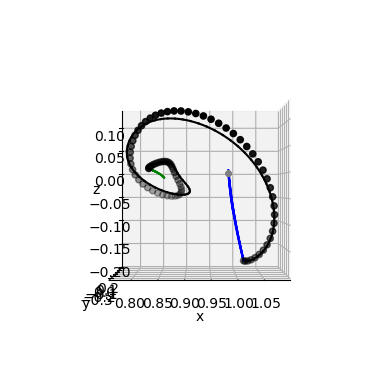

In [9]:
# plot trajectory
fig, ax, sols_check = prob.plot_trajectory(use_itm_nodes=False, show_maneuvers=False)

# in-between guesses
# for _sols in iter_sols:
#     for _sol in _sols:
#         ax.plot(_sol.y[0,:], _sol.y[1,:], _sol.y[2,:], color='black', lw=0.5)

ax.plot(sol0_ballistic.y[0,:], sol0_ballistic.y[1,:], sol0_ballistic.y[2,:], color='blue')
ax.plot(solf_ballistic.y[0,:], solf_ballistic.y[1,:], solf_ballistic.y[2,:], color='green')
stardust.plot_sphere_wireframe(ax, 1737/384400, [1-mu,0,0], color='grey')
ax.set(xlabel="x", ylabel="y", zlabel="z")
ax.set_aspect('equal', 'box')
ax.view_init(0,270)
plt.show()

AttributeError: module 'stardust' has no attribute 'plot_circle'

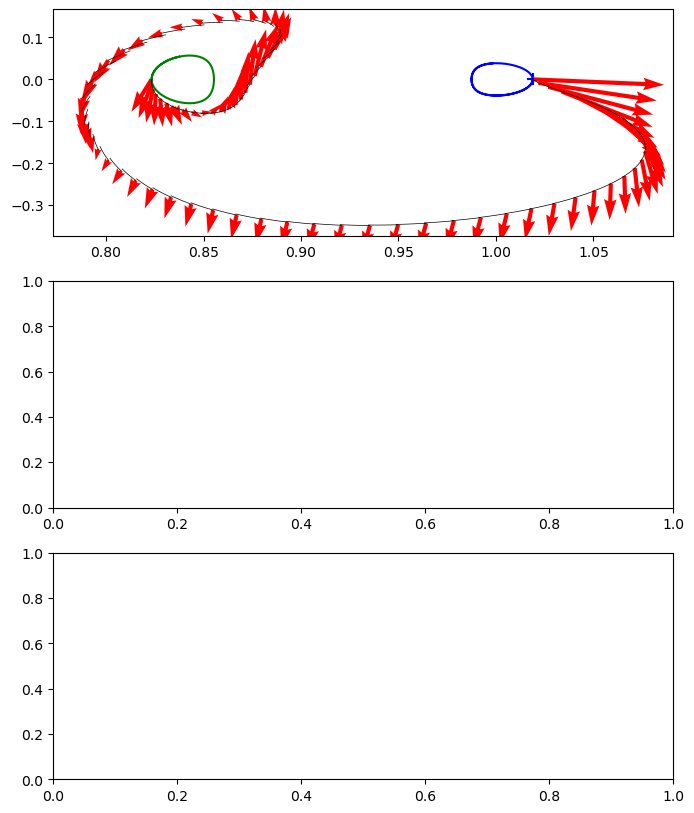

In [10]:
fig, axs = plt.subplots(3,1,figsize=(8,10))

ixys = [[0,1], [0,2], [1,2]]
labels = [['x, LU', 'y, LU'], ['x, LU', 'z, LU'], ['y, LU', 'z, LU']]
for ixy,ax,label in zip(ixys, axs, labels):
    ax.plot(sol0_ballistic.y[ixy[0],:], sol0_ballistic.y[ixy[1],:], color='blue', label='initial orbit')
    ax.plot(solf_ballistic.y[ixy[0],:], solf_ballistic.y[ixy[1],:], color='green', label='final orbit')
    for sol in sols_transfer:
        ax.plot(sol.y[ixy[0],:], sol.y[ixy[1],:], color='black', lw=0.5)
    ax.scatter(rv0[ixy[0]], rv0[ixy[1]], color='blue', marker="+", s=80)
    ax.quiver(prob.nodes[:,ixy[0]], prob.nodes[:,ixy[1]], 
            prob.v_residuals[:,ixy[0]], prob.v_residuals[:,ixy[1]],
            color='red')
    stardust.plot_circle(ax, 1737/LU, [1-mu,0], color='grey')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set(xlabel=label[0], ylabel=label[1])
plt.tight_layout()
plt.show()

In [36]:
pos_error = np.linalg.norm(sols_check[-1].y[0:3,-1] - rvf[0:3])
vel_error = np.linalg.norm(sols_check[-1].y[3:6,-1] + prob.v_residuals[-1] - rvf[3:])
print(f"Final position error = {pos_error}")
print(f"Final velocity error = {vel_error}")
assert pos_error < 1e-11
assert vel_error < 1e-11

Final position error = 5.003886037467777e-15
Final velocity error = 0.0
